# Importing libraries

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [0]:
import pandas as pd
import numpy as np
import os
import re    # for regular expressions 
import nltk  # for text manipulation 
import string 
import warnings 
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt  
 

In [0]:
#os.getcwd()

# Loading train and test data
# Checking missing values

In [0]:
dftrain = pd.read_csv('/gdrive/My Drive/Colab Notebooks/train_av.csv')

In [6]:
dftrain.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [7]:
print(dftrain.isnull().values.any())

False


In [0]:
dftest = pd.read_csv('/gdrive/My Drive/Colab Notebooks/test_av.csv')

In [9]:
dftest.head()

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


In [10]:
print(dftest.isnull().sum())

id       0
tweet    0
dtype: int64


In [11]:
dftrain['label'].value_counts()

0    29720
1     2242
Name: label, dtype: int64

# Distribution of data

In [12]:
cnt1 = len(dftrain[dftrain['label']==1])
cnt0 = len(dftrain[dftrain['label']==0])
pct0 = cnt0/(cnt1+cnt0)
print('percent 0',round(pct0*100,2))
pct1 = cnt1/(cnt0+cnt1)
print('percent 1',round(pct1*100,2))


percent 0 92.99
percent 1 7.01


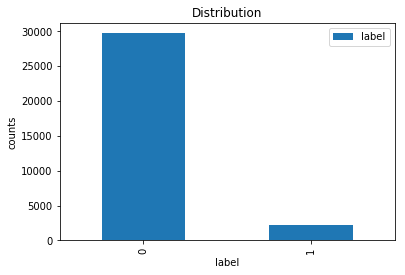

In [13]:
pd.value_counts(dftrain['label']).plot.bar()
plt.title('Distribution')
plt.xlabel('label')
plt.ylabel('counts')
plt.legend()
plt.show()

In [14]:
dftrain.shape

(31962, 3)

In [15]:
dftest.shape

(17197, 2)

In [0]:
#len(dftrain['tweet'])

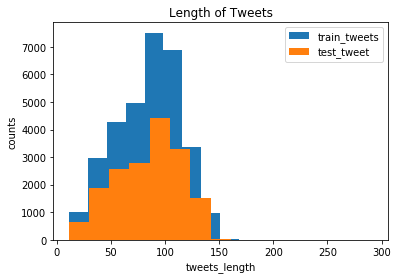

In [17]:
trainlen = dftrain['tweet'].str.len()
testlen = dftest['tweet'].str.len()
plt.hist(trainlen,label ='train_tweets',bins=15)
plt.hist(testlen,label = 'test_tweet',bins=15)
plt.title('Length of Tweets')
plt.xlabel('tweets_length')
plt.ylabel('counts')
plt.legend()
plt.show()

In [18]:
# get a word count per sentence column
def word_count(sentence):
    return len(sentence.split())
    
dftrain['word count'] = dftrain['tweet'].apply(word_count)
dftrain.head(3)


,id,label,tweet,word count
0,1,0,@user when a father is dysfunctional and is s...,18
1,2,0,@user @user thanks for #lyft credit i can't us...,19
2,3,0,bihday your majesty,3


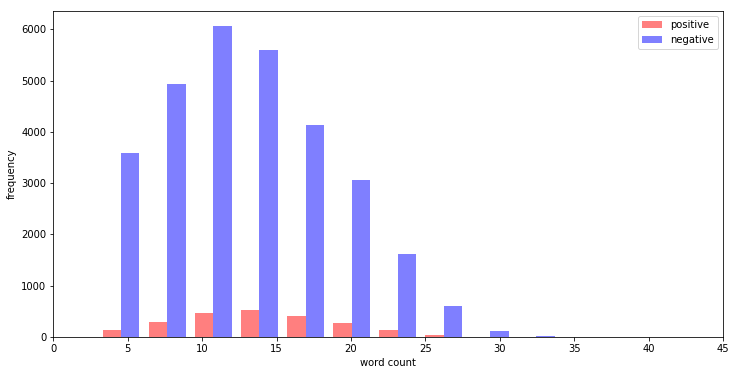

In [19]:
x = dftrain['word count'][dftrain.label == 1]
y = dftrain['word count'][dftrain.label == 0]
plt.figure(figsize=(12,6))
plt.xlim(0,45)
plt.xlabel('word count')
plt.ylabel('frequency')
g = plt.hist([x, y], color=['r','b'], alpha=0.5, label=['positive','negative'])
plt.legend(loc='upper right')

# Getting most common words in training dataset


In [0]:
import nltk
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem.wordnet import WordNetLemmatizer #Load #training dataset to Pandas and preview the top rows.
from collections import Counter

In [21]:
all_words = []
for line in list(dftrain['tweet']):
    words = line.split()
    for word in words:
        all_words.append(word.lower())
Counter(all_words).most_common(10)    
    


[('@user', 17291),
 ('the', 10065),
 ('to', 9768),
 ('a', 6261),
 ('i', 5655),
 ('you', 4949),
 ('and', 4831),
 ('in', 4570),
 ('for', 4435),
 ('of', 4152)]

In [22]:
data = dftrain.append(dftest,ignore_index=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [23]:
data.head()


,id,label,tweet,word count
0,1,0.0,@user when a father is dysfunctional and is s...,18.0
1,2,0.0,@user @user thanks for #lyft credit i can't us...,19.0
2,3,0.0,bihday your majesty,3.0
3,4,0.0,#model i love u take with u all the time in ...,14.0
4,5,0.0,factsguide: society now #motivation,4.0


In [24]:
# helper function to clean tweets
'''def processTweet(tweet):
    # Remove HTML special entities (e.g. &amp;)
    tweet = re.sub(r'\&\w*;', '', tweet)
    #Convert @username to AT_USER
    tweet = re.sub('@[^\s]+','',tweet)
    # Remove tickers
    tweet = re.sub(r'\$\w*', '', tweet)
    # To lowercase
    tweet = tweet.lower()
    # Remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*\/\w*', '', tweet)
    # Remove hashtags
    tweet = re.sub(r'#\w*', '', tweet)
    # Remove Punctuation and split 's, 't, 've with a space for filter
    #tweet = re.sub(r'[' + punctuation.replace('@', '') + ']+', ' ', tweet)
    # Remove words with 2 or fewer letters
    tweet = re.sub(r'\b\w{1,2}\b', '', tweet)
    # Remove whitespace (including new line characters)
    tweet = re.sub(r'\s\s+', ' ', tweet)
    # Remove single space remaining at the front of the tweet.
    tweet = tweet.lstrip(' ') 
    # Remove characters beyond Basic Multilingual Plane (BMP) of Unicode:
    tweet = ''.join(c for c in tweet if c <= '\uFFFF') 
    return tweet'''


"def processTweet(tweet):\n    # Remove HTML special entities (e.g. &amp;)\n    tweet = re.sub(r'\\&\\w*;', '', tweet)\n    #Convert @username to AT_USER\n    tweet = re.sub('@[^\\s]+','',tweet)\n    # Remove tickers\n    tweet = re.sub(r'\\$\\w*', '', tweet)\n    # To lowercase\n    tweet = tweet.lower()\n    # Remove hyperlinks\n    tweet = re.sub(r'https?:\\/\\/.*\\/\\w*', '', tweet)\n    # Remove hashtags\n    tweet = re.sub(r'#\\w*', '', tweet)\n    # Remove Punctuation and split 's, 't, 've with a space for filter\n    #tweet = re.sub(r'[' + punctuation.replace('@', '') + ']+', ' ', tweet)\n    # Remove words with 2 or fewer letters\n    tweet = re.sub(r'\x08\\w{1,2}\x08', '', tweet)\n    # Remove whitespace (including new line characters)\n    tweet = re.sub(r'\\s\\s+', ' ', tweet)\n    # Remove single space remaining at the front of the tweet.\n    tweet = tweet.lstrip(' ') \n    # Remove characters beyond Basic Multilingual Plane (BMP) of Unicode:\n    tweet = ''.join(c for c 

In [0]:
#clean dataframe's text column
#data['tweet'] = data['tweet'].apply(processTweet)
# preview some cleaned tweets
#data['tweet'].head()

# Data Preprocessing

# Remove @ symbol

In [0]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
    return input_txt 

In [27]:
data['tidy_tweet'] = np.vectorize(remove_pattern)(data['tweet'], "@[\w]*") 
data.head()

,id,label,tweet,word count,tidy_tweet
0,1,0.0,@user when a father is dysfunctional and is s...,18.0,when a father is dysfunctional and is so sel...
1,2,0.0,@user @user thanks for #lyft credit i can't us...,19.0,thanks for #lyft credit i can't use cause th...
2,3,0.0,bihday your majesty,3.0,bihday your majesty
3,4,0.0,#model i love u take with u all the time in ...,14.0,#model i love u take with u all the time in ...
4,5,0.0,factsguide: society now #motivation,4.0,factsguide: society now #motivation


# Remove Punctuations,special symbols

In [28]:
data['tidy_tweet'] = data['tidy_tweet'].str.replace("[^a-zA-Z#]", " ") 
data.head(10)

,id,label,tweet,word count,tidy_tweet
0,1,0.0,@user when a father is dysfunctional and is s...,18.0,when a father is dysfunctional and is so sel...
1,2,0.0,@user @user thanks for #lyft credit i can't us...,19.0,thanks for #lyft credit i can t use cause th...
2,3,0.0,bihday your majesty,3.0,bihday your majesty
3,4,0.0,#model i love u take with u all the time in ...,14.0,#model i love u take with u all the time in ...
4,5,0.0,factsguide: society now #motivation,4.0,factsguide society now #motivation
5,6,0.0,[2/2] huge fan fare and big talking before the...,19.0,huge fan fare and big talking before the...
6,7,0.0,@user camping tomorrow @user @user @user @use...,11.0,camping tomorrow danny
7,8,0.0,the next school year is the year for exams.ð...,21.0,the next school year is the year for exams ...
8,9,0.0,we won!!! love the land!!! #allin #cavs #champ...,11.0,we won love the land #allin #cavs #champ...
9,10,0.0,@user @user welcome here ! i'm it's so #gr...,10.0,welcome here i m it s so #gr


# Remove short words

In [0]:
data['tidy_tweet'] = data['tidy_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

# normalization

In [30]:
tokenized_tweet = data['tidy_tweet'].apply(lambda x: x.split()) # tokenizing 
tokenized_tweet.head()

0    [when, father, dysfunctional, selfish, drags, ...
1    [thanks, #lyft, credit, cause, they, offer, wh...
2                              [bihday, your, majesty]
3                     [#model, love, take, with, time]
4                   [factsguide, society, #motivation]
Name: tidy_tweet, dtype: object

In [0]:
from nltk.stem.porter import * 
stemmer = PorterStemmer() 
tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) # stemming

# Word Cloud

In [0]:
data['tidy_tweet']=tokenized_tweet

In [33]:
data['tidy_tweet'].head()

0    [when, father, dysfunct, selfish, drag, kid, i...
1    [thank, #lyft, credit, caus, they, offer, whee...
2                              [bihday, your, majesti]
3                     [#model, love, take, with, time]
4                         [factsguid, societi, #motiv]
Name: tidy_tweet, dtype: object

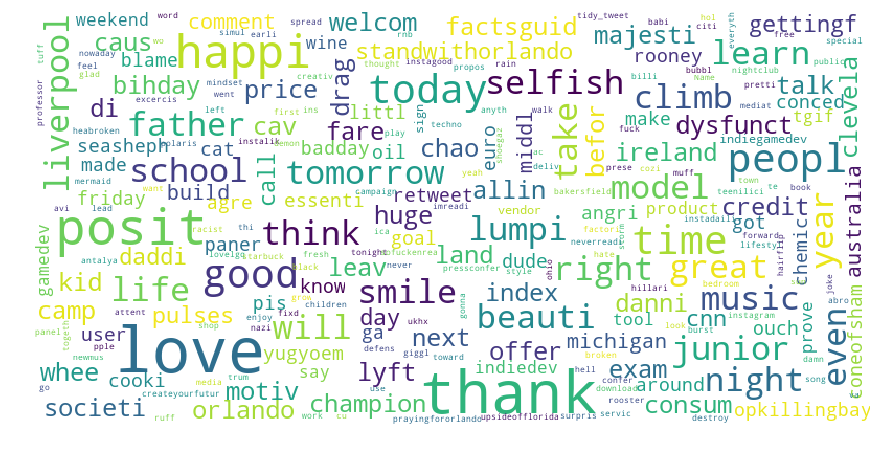

In [34]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=250,
        max_font_size=30,
        scale=2,
        random_state=5 #chosen a andom by flipping a coin; it was heads
).generate(str(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)
    plt.imshow(wordcloud)
    plt.show()

wordcloud(data['tidy_tweet'])

# word cloud for label 0

In [0]:
normal_words =' '.join([str(text) for text in data['tidy_tweet'][data['label'] == 0]]) 


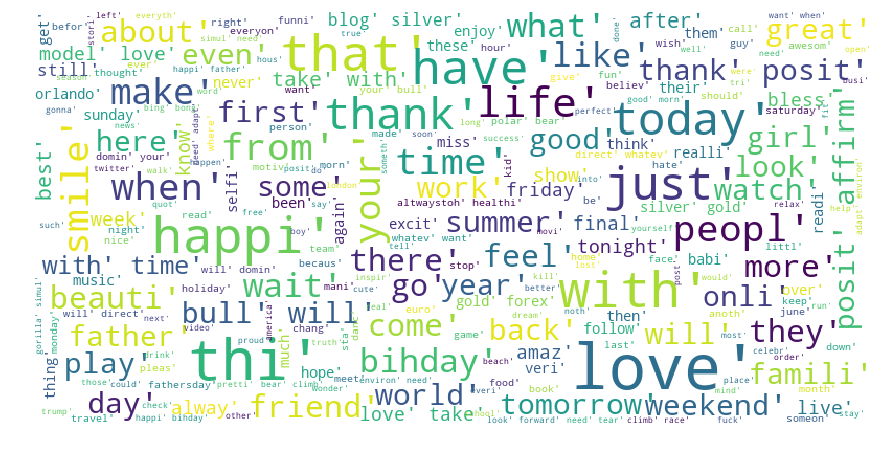

In [36]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=250,
        max_font_size=30,
        scale=2,
        random_state=5 #chosen a andom by flipping a coin; it was heads
).generate(str(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)
    plt.imshow(wordcloud)
    plt.show()

wordcloud(normal_words)

# word cloud for label 1

In [0]:
normal_words =' '.join([str(text) for text in data['tidy_tweet'][data['label'] == 1]]) 


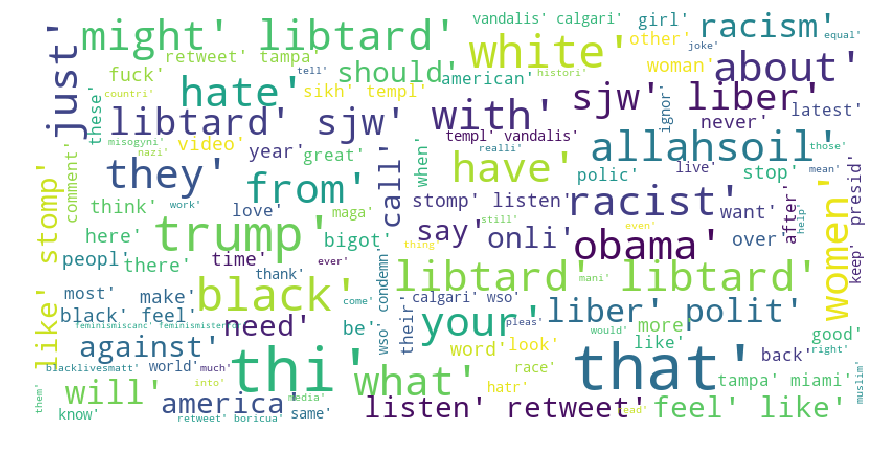

In [38]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=250,
        max_font_size=30,
        scale=2,
        random_state=5 #chosen a andom by flipping a coin; it was heads
).generate(str(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)
    plt.imshow(wordcloud)
    plt.show()

wordcloud(normal_words)

In [0]:
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])    
data['tidy_tweet'] = tokenized_tweet

In [40]:
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
bow = bow_vectorizer.fit_transform(data['tidy_tweet'])
bow.shape

(49159, 1000)

# TF-IDF

In [0]:
#from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer 

#import gensim


In [0]:
#vectorize_word = TfidfVectorizer(sublinear_tf=True,strip_accents='unicode',analyzer='word',token_pattern=r'\w{1,}',stop_words='english',ngram_range=(1, 1),max_features=10000)

In [0]:
#data1 = data['tidy_tweet']

In [0]:
#vectorize_word.fit(data1)
#train_features_word = vectorize_word.transform(data1)

In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english') 
tfidf = tfidf_vectorizer.fit_transform(data['tidy_tweet']) 
tfidf.shape

(49159, 1000)

In [0]:
#texts = [[word.lower() for word in line.split()] for line in data]


# Word2Vec

In [45]:
import gensim
tokenized_tweet = data['tidy_tweet'].apply(lambda x: x.split()) # tokenizing 
model_w2v = gensim.models.Word2Vec(
            tokenized_tweet,
            size=200, # desired no. of features/independent variables
            window=5, # context window size
            min_count=2,
            sg = 1, # 1 for skip-gram model
            hs = 0,
            negative = 10, # for negative sampling
            workers= 2, # no.of cores
            seed = 34) 

model_w2v.train(tokenized_tweet, total_examples= len(data['tidy_tweet']), epochs=20)

(6510028, 7536020)

In [46]:
model_w2v.wv.most_similar(positive="trump")
model_w2v['food']
len(model_w2v['food']) #The length of the vector is 200


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


200

In [0]:
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += model_w2v[word].reshape((1, size))
            count += 1.
        except KeyError: # handling the case where the token is not in vocabulary continue
            if count != 0:
              vec /= count
    return vec

# preparing word2vec feature set

In [48]:
wordvec_arrays = np.zeros((len(tokenized_tweet), 200)) 
for i in range(len(tokenized_tweet)):
    wordvec_arrays[i,:] = word_vector(tokenized_tweet[i], 200)
    wordvec_df = pd.DataFrame(wordvec_arrays)
    wordvec_df.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [0]:
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import f1_score


In [0]:
train_bow = bow[:31962,:] 
test_bow = bow[31962:,:]
xtrain_bow, xvalid_bow, ytrain, yvalid = train_test_split(train_bow, dftrain['label'],random_state=42,test_size = 0.3)

# Logistic regression

# BOW

In [51]:
lreg = LogisticRegression() 
# training the model
lreg.fit(xtrain_bow, ytrain) 
prediction = lreg.predict_proba(xvalid_bow) # predicting on the validation set 
prediction_int = prediction[:,1] >= 0.3 # if prediction is greater than or equal to 0.3 than 1 else 0 
prediction_int = prediction_int.astype(np.int) 
f1_score(yvalid, prediction_int) # calculating f1 score for the validation set

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.5307820299500832

In [0]:
test_pred = lreg.predict_proba(test_bow) 
test_pred_int = test_pred[:,1] >= 0.3
test_pred_int = test_pred_int.astype(np.int) 
dftest['label'] = test_pred_int 
submission = dftest[['id','label']] 
submission.to_csv('/gdrive/My Drive/Colab Notebooks/sub_lreg_bow.csv', index=False) # writing data to a CSV file

# TFIDF 

In [53]:
train_tfidf = tfidf[:31962,:] 
test_tfidf = tfidf[31962:,:] 
xtrain_tfidf = train_tfidf[ytrain.index] 
xvalid_tfidf = train_tfidf[yvalid.index]
lreg.fit(xtrain_tfidf, ytrain) 
prediction = lreg.predict_proba(xvalid_tfidf)
prediction_int = prediction[:,1] >= 0.3 
prediction_int = prediction_int.astype(np.int) 
f1_score(yvalid, prediction_int) # calculating f1 score for the validation set

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.5469026548672566

# Word2Vec

In [54]:
train_w2v = wordvec_df.iloc[:31962,:]
test_w2v = wordvec_df.iloc[31962:,:] 
xtrain_w2v = train_w2v.iloc[ytrain.index,:] 
xvalid_w2v = train_w2v.iloc[yvalid.index,:]
lreg.fit(xtrain_w2v, ytrain) 
prediction = lreg.predict_proba(xvalid_w2v)
prediction_int = prediction[:,1] >= 0.3 
prediction_int = prediction_int.astype(np.int)
f1_score(yvalid, prediction_int)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.5823195458231955

In [0]:
from sklearn import svm


# SVM on Word2Vec

In [0]:
svc = svm.SVC(kernel='linear', C=1, probability=True).fit(xtrain_w2v, ytrain) 


In [57]:
prediction = svc.predict_proba(xvalid_w2v) 
prediction_int = prediction[:,1] >= 0.3 
prediction_int = prediction_int.astype(np.int) 
f1_score(yvalid, prediction_int)

0.5893635571054926